# Capstone Project - Are big cities overrated?
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction:  Business Problem <a name="introduction"></a>

When people try to decide where to work and or live, we face multiple choices. You may appreciate to live in metropolis like New York and Los Angeles, or you may prefer smaller but quitter cities which people may not even know their names. Conventional wisdom tells people that if you want prosperity, go to big cities because those are where opportunities  lie. However, this opinion is now challenged. Planet Money got a letter from a listener named Dennis Simpson. His argument had a lot to do with where he lives - Hot Springs Village, Ark. Hot Springs Village has 9 golf courses and 11 lakes. It's got clean water and little crime or traffic. And on top of all this, Simpson says, the town is dirt cheap, especially when compared to our nation's big cities, which brings us to his argument: cities are overrated. Big cities simply aren't worth the cost. 

In this project, we leverage some public data, and will try to address the problem: **are big cities overrated**? This project will give people some insight when they are faced with the choices of small or big cities.

## Data <a name='data'></a>
 
To determine if big cities are overrated, we need the following data
* basic city information e.g. population, median household income, median house price
* demographic data of ethnicity composition
* crime data 
* venue data 

The above data are nevertheless not exhaustive, you can come up with more data pertent to cities. We will use public data from the following sauce
* http://www.city-data.com/
* https://foursquare.com/

import libraries

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy import Nominatim
from four_square_credentials import CLIENT_ID, CLIENT_SECRET 

let's choose some city candidates. You can come up with your own city of candidates

In [7]:
big_cities = ['San Francisco, California','New York, New York','Los Angeles, California',
              'Seattle, Washington']
small_cities = ['Hot Springs Village, Arkansas','Boulder, Colorado','Greenville, South Carolina',
                'Dayton, Ohio']

define functions that scape data and do api calls to four square.

In [9]:
def scrape_city_data(city):
    '''
    input: city name, state name
    output: pandas dataframes:
            1. city basic info
            2. race composition table
            3. crime index table scrapped from http://www.city-data.com/
    '''
    url = 'http://www.city-data.com/city/{}.html'.format(city.replace(',','').replace(' ','-'))
    html = requests.get(url).text
    soup = BeautifulSoup(html,'html.parser')

    population = soup.find(id='city-population').text.split('.')[0]
    median_resident_age = soup.find_all(id='median-age')[0].find('tr').text
    median_household_income = soup.find(id='median-income').text.split('\n')[0]
    median_house_or_condo_value = soup.find(id='median-income').text.split('\n')[4]
    median_gross_rent = soup.find(id='median-rent').text
    mean_travel_time_to_work = soup.find(id='education-info').find_all('li')[-1].text
    info_desc = [population,median_resident_age,median_household_income,median_house_or_condo_value,
                median_gross_rent,mean_travel_time_to_work]
    desc = [desc.split(':')[0] for desc in info_desc]
    desc_value = [desc.split(':')[1].strip() for desc in info_desc]
    info_df = pd.DataFrame({'description':desc,'value':desc_value})

    race_df = pd.DataFrame(columns=['race','population','percentage(%)'])
    race_table = soup.find(lambda tag: tag.name == 'ul' and tag.get('class') == ['list-group'])
    race_rows = race_table.find_all(lambda tag: tag.name == 'li' and tag.get('class') == ['list-group-item'])
    for i,row in enumerate(race_rows):
        race_df.loc[i,'race'] = row.find('b').text
        race_df.loc[i,'population'] = int(row.find(class_="badge").text.replace(',',''))
        race_df.loc[i,'percentage(%)'] = float(row.find(class_="badge alert-info").text.strip('%'))

    if soup.find(id='crime'): #some city doesn't have crime data
        crime_table = soup.find('table',class_='crime tabBlue table')
        table_head = crime_table.find_all('th')[1:]
        crime_year = [year.text for year in table_head]
        table_foot = crime_table.find('tfoot').find_all('td')[1:]
        crime_index = [foot.text for foot in table_foot]
        crime_df = pd.DataFrame({'year':crime_year,'crime_index':crime_index})
        return info_df, race_df, crime_df
    return info_df, race_df


def city_venue(city):
    global CLIENT_ID, CLIENT_SECRET
    '''
    input: city name, state name
    output: pandas dataframe of 100 venues in city downtown area (if any)
    '''
    geolocator = Nominatim(user_agent='capstone_project')
    geolocation = geolocator.geocode(city)
    city_latitude = geolocation.latitude
    city_longitude = geolocation.longitude
    VERSION = '20190627' # Foursquare API version
    RADIUS = 500
    LIMIT = 100

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        city_latitude,
        city_longitude,
        RADIUS,
        LIMIT)

    res = requests.get(url).json()
    venue_list = res['response']['groups'][0]['items']
    venue_df = pd.DataFrame(columns=['venue_name','venue_category','venue_lat','venue_lng'])
    for i, venue in enumerate(venue_list):
        venue_name = venue['venue']['name']
        venue_category = venue['venue']['categories'][0]['name']
        venue_lat = venue['venue']['location']['lat']
        venue_lng = venue['venue']['location']['lng']
        venue_df.loc[i,'venue_name'] = venue_name
        venue_df.loc[i,'venue_category'] = venue_category
        venue_df.loc[i,'venue_lat'] = venue_lat
        venue_df.loc[i,'venue_lng'] = venue_lng
    return venue_df

create a dictionary that links city with its profile, i.e. info, race, crime, venue

In [10]:
city_profile = {}
for city in big_cities+small_cities:   
    venue_df = city_venue(city)  #api calls to foursquare
    if len(scrape_city_data(city))==3: #if there is crime data
        info_df, race_df, crime_df = scrape_city_data(city)
        city_profile[city] = {'info_df':info_df,
                              'race_df':race_df,
                              'crime_df':crime_df,
                              'venue_df':venue_df}
    else: #some city doesn't have crime data
        info_df, race_df = scrape_city_data(city)
        city_profile[city] = {'info_df':info_df,
                              'race_df':race_df,
                              'venue_df':venue_df}

we can see some examples of the collected data

In [11]:
city_profile['Los Angeles, California']['info_df']

,description,value
0,Population in 2016,"3,976,324"
1,Median resident age,35.6 years
2,Estimated median household income in 2016,"$54,432 (it was $36,687 in 2000)"
3,Estimated median house or condo value in 2016,"$593,500 (it was $215,600 in 2000)"
4,Median gross rent in 2016,"$1,315."
5,Mean travel time to work (commute),29.8 minutes


In [12]:
city_profile['Los Angeles, California']['race_df']

,race,population,percentage(%)
0,Hispanic,1944758,48.9
1,White alone,1133715,28.5
2,Asian alone,446561,11.2
3,Black alone,337134,8.5
4,Two or more races,85982,2.2
5,Other race alone,17186,0.4
6,American Indian alone,6419,0.2
7,Native Hawaiian and OtherPacific Islander alone,4569,0.1


In [16]:
city_profile['Los Angeles, California']['crime_df'].tail(5)

,year,crime_index
10,2012,267.2
11,2013,244.5
12,2014,258.6
13,2015,318.7
14,2016,347.1


In [15]:
city_profile['Los Angeles, California']['venue_df'].head(10)

,venue_name,venue_category,venue_lat,venue_lng
0,Grand Park,Park,34.055,-118.245
1,Badmaash,Indian Restaurant,34.0513,-118.245
2,Redbird,American Restaurant,34.0507,-118.244
3,CVS pharmacy,Pharmacy,34.0534,-118.242
4,Kinokuniya Bookstore,Bookstore,34.0501,-118.242
5,Kasih,Indonesian Restaurant,34.0502,-118.243
6,JiST Cafe,Breakfast Spot,34.0509,-118.24
7,Curry House,Japanese Curry Restaurant,34.0501,-118.242
8,2nd Street Cigar Lounge & Gallery,Art Gallery,34.0515,-118.245
9,The Edison,Speakeasy,34.0511,-118.245


This concludes the data gathering phase. we're now ready to use this data to gain some insights from comparison between big cities and small cities.

## Methodology <a name='methodology'></a>

In this section, we will do some direct comparison between data grouped by big cities and small cities. Visual plots will provide most appealing tools for people to draw conclusions. 

* From city basic info data, we can get some general ideas of what lifes are like in big and small cities. 
* From city race data, we can get a clear picture what are the main ethnicity groups in big and small cities. 
* From city crime data, we can see the trend of crime index in big and small cities over the years.
* From the city venue data, we can see how many venues are in the downtown area since we limit the searching area to 500 meters away from city center. 

## Analysis <a name='analysis'></a>

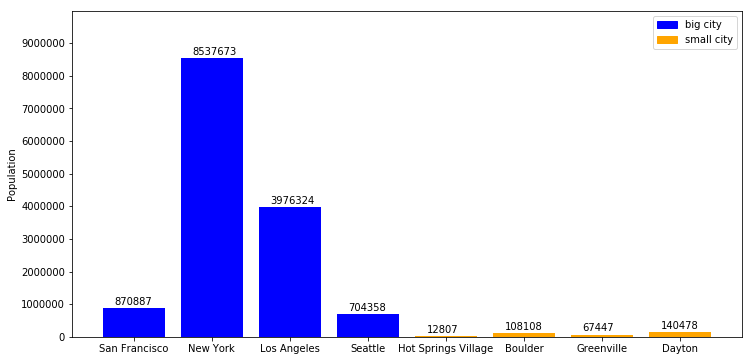

In [27]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    population = city_profile[big_city]['info_df'].iloc[0,1]
    population = int(population.replace(',',''))  
    plt.bar(big_city.split(',')[0], population, color='blue')
    plt.text(i-0.25,population+100000,population)
for i,small_city in enumerate(small_cities):
    population = city_profile[small_city]['info_df'].iloc[0,1]
    population = int(population.replace(',',''))  
    plt.bar(small_city.split(',')[0], population, color='orange') 
    plt.text(i+len(big_cities)-0.25,population+100000,population)
plt.ylabel('Population')    
plt.ylim(0,10000000)
plt.yticks(range(0,10000000,1000000))
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Population.jpeg')

It can be seen the so called "big cities" are those who have population around a million or more. New York is the most populated city in the US. Small cities usually have tens of thousands of people.

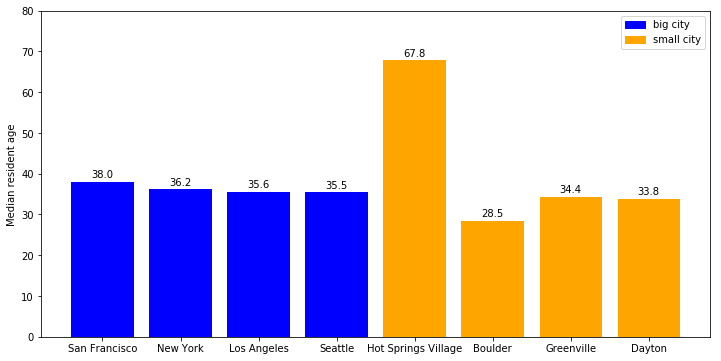

In [38]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    age = city_profile[big_city]['info_df'].iloc[1,1]
    age = float(age.rstrip(' years'))  
    plt.bar(big_city.split(',')[0], age, color='blue')
    plt.text(i-0.15,age+1,age)
for i,small_city in enumerate(small_cities):
    age = city_profile[small_city]['info_df'].iloc[1,1]
    age = float(age.rstrip(' years'))  
    plt.bar(small_city.split(',')[0], age, color='orange') 
    plt.text(i+len(big_cities)-0.15,age+1,age)
plt.ylabel('Median resident age')    
plt.ylim(0,80)
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Median resident age.jpeg')

It might be true that people who lives in Hot Springs Village are quite old, or it might be the source of the data is not very accurate.

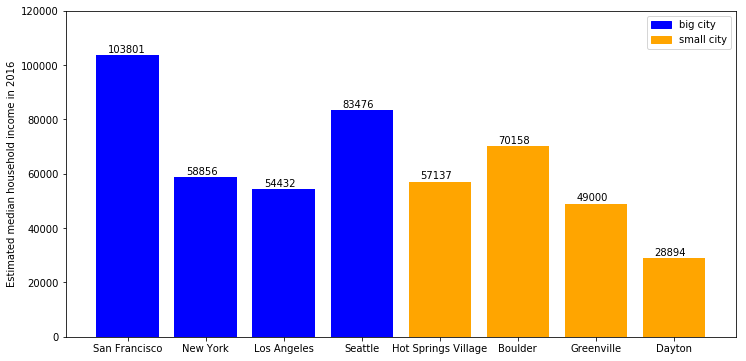

In [39]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    income = city_profile[big_city]['info_df'].iloc[2,1]
    income = int(re.search(r'^\$\d{1,3},\d{3}',income).group().strip('$').replace(',',''))
    plt.bar(big_city.split(',')[0], income, color='blue')
    plt.text(i-0.25, income+1000, income)
for i,small_city in enumerate(small_cities):
    income = city_profile[small_city]['info_df'].iloc[2,1]
    income = int(re.search(r'^\$\d{1,3},\d{3}',income).group().strip('$').replace(',',''))
    plt.bar(small_city.split(',')[0], income, color='orange') 
    plt.text(i+len(big_cities)-0.25, income+1000, income)
plt.ylabel('Estimated median household income in 2016')  
plt.ylim(0,120000)
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Estimated median household income in 2016.jpeg')

In general, big cities median household income are higher than small cities. However, there are some small cities have quite high median household income, such as Boulder. A side note: U.S. real median household income reached \$61,372 in 2017, an increase of \$1,063 or 1.8% vs. 2016.

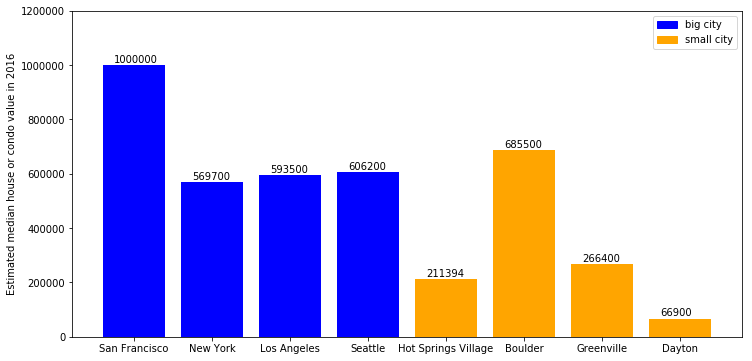

In [40]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    house_value = city_profile[big_city]['info_df'].iloc[3,1]
    house_value = int(re.search(r'\$\d*,*\d{2,3},\d{3}',house_value).group().strip('$').replace(',',''))
    plt.bar(big_city.split(',')[0], house_value, color='blue')
    plt.text(i-0.25, house_value+10000, house_value)
for i,small_city in enumerate(small_cities):
    house_value = city_profile[small_city]['info_df'].iloc[3,1]
    house_value = int(re.search(r'\$\d*,*\d{2,3},\d{3}',house_value).group().strip('$').replace(',',''))
    plt.bar(small_city.split(',')[0], house_value, color='orange') 
    plt.text(i+len(big_cities)-0.25, house_value+10000, house_value)
plt.ylabel('Estimated median house or condo value in 2016')
plt.ylim(0,1200000)
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Estimated median house or condo value in 2016.jpeg')

San Francisco has the most expensive houses. Again, Boulder stands out in terms of housing price.

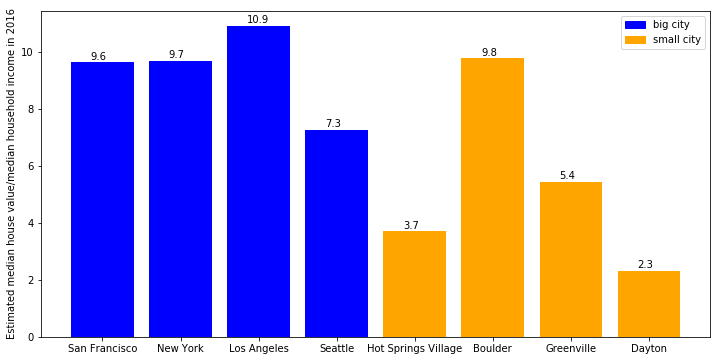

In [41]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    income = city_profile[big_city]['info_df'].iloc[2,1]
    income = int(re.search(r'^\$\d{1,3},\d{3}',income).group().strip('$').replace(',',''))
    house_value = city_profile[big_city]['info_df'].iloc[3,1]
    house_value = int(re.search(r'\$\d*,*\d{2,3},\d{3}',house_value).group().strip('$').replace(',',''))
    plt.bar(big_city.split(',')[0], house_value/income, color='blue')
    plt.text(i-0.15, house_value/income+0.1, '{:.1f}'.format(house_value/income))
for i,small_city in enumerate(small_cities):
    income = city_profile[small_city]['info_df'].iloc[2,1]
    income = int(re.search(r'^\$\d{1,3},\d{3}',income).group().strip('$').replace(',',''))
    house_value = city_profile[small_city]['info_df'].iloc[3,1]
    house_value = int(re.search(r'\$\d*,*\d{2,3},\d{3}',house_value).group().strip('$').replace(',',''))
    plt.bar(small_city.split(',')[0], house_value/income, color='orange') 
    plt.text(i+len(big_cities)-0.15, house_value/income+0.1, '{:.1f}'.format(house_value/income))
plt.ylabel('Estimated median house value/median household income in 2016')
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Estimated median house value divided by median household income in 2016.jpeg')

I think it's interesting to calculate the division of median housing price by median household income. The results sadden me because I live in Los Angeles.

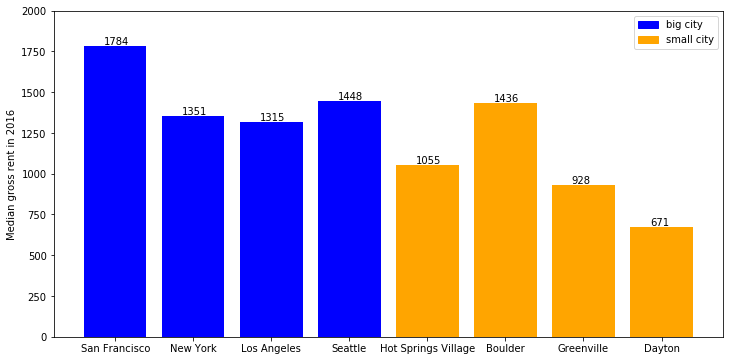

In [42]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    rent = city_profile[big_city]['info_df'].iloc[4,1]
    rent = int(rent.strip('$.').replace(',',''))
    plt.bar(big_city.split(',')[0], rent, color='blue')
    plt.text(i-0.15, rent+10, rent)
for i,small_city in enumerate(small_cities):
    rent = city_profile[small_city]['info_df'].iloc[4,1]
    rent = int(rent.strip('$.').replace(',',''))
    plt.bar(small_city.split(',')[0], rent, color='orange') 
    plt.text(i+len(big_cities)-0.15, rent+10, rent)
plt.ylabel('Median gross rent in 2016')    
plt.ylim(0,2000)
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Median gross rent in 2016.jpeg')

San Francisco, again, claims the crown in terms of rent.

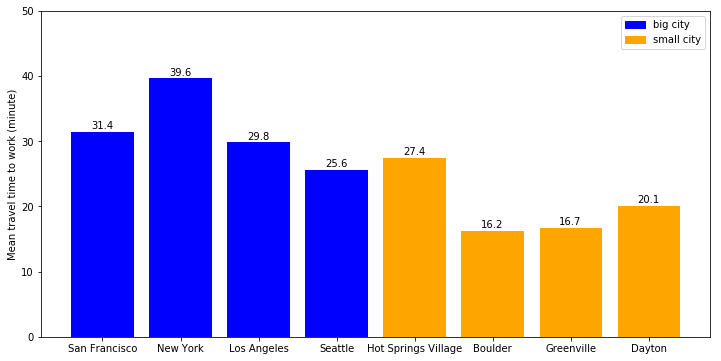

In [43]:
plt.figure(figsize=(12,6))

for i,big_city in enumerate(big_cities):
    commute = city_profile[big_city]['info_df'].iloc[5,1]
    commute = float(commute.strip(' minutes'))
    plt.bar(big_city.split(',')[0], commute, color='blue')
    plt.text(i-0.15, commute+0.5, commute)
for i,small_city in enumerate(small_cities):
    commute = city_profile[small_city]['info_df'].iloc[5,1]
    commute = float(commute.strip(' minutes'))
    plt.bar(small_city.split(',')[0], commute, color='orange') 
    plt.text(i+len(big_cities)-0.15, commute+0.5, commute)
plt.ylabel('Mean travel time to work (minute)')  
plt.ylim(0,50)
blue_patch = mpatches.Patch(color='blue', label='big city')
orange_patch = mpatches.Patch(color='orange', label='small city')
plt.legend(handles=[blue_patch, orange_patch])

plt.savefig('Mean travel time to work.jpeg')

New York - Capital of traffic congestion

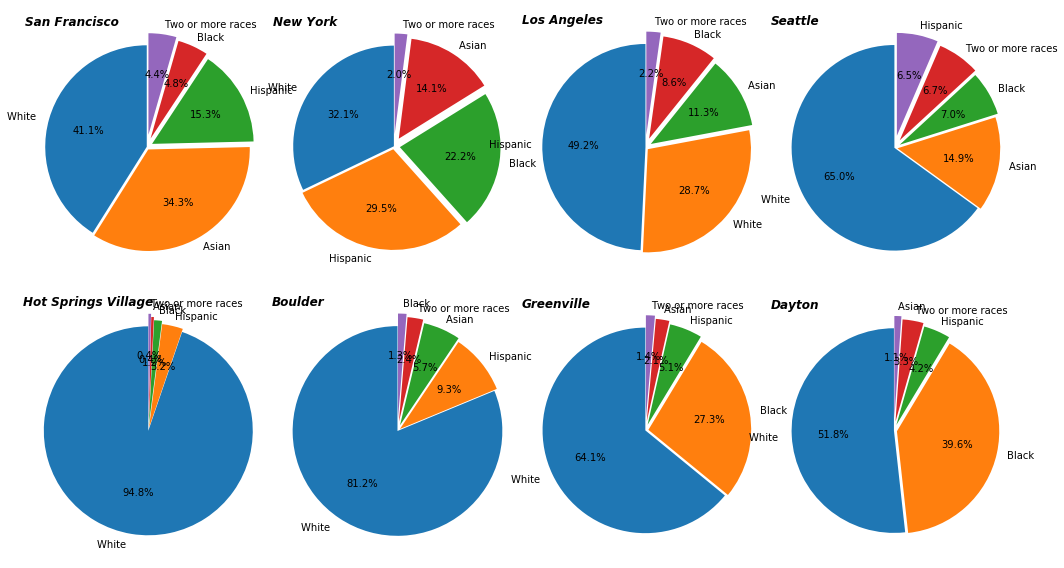

In [44]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,8))

for i,big_city in enumerate(big_cities):
    labels = city_profile[big_city]['race_df']['race'].str.rstrip('alone').values[:5] #top 5 races
    sizes = city_profile[big_city]['race_df']['percentage(%)'].values[:5]
    explode = [0,0.03,0.06,0.09,0.12]

    ax[0,i].pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=90)
    ax[0,i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[0,i].text(-1.2,1.2, big_city.split(',')[0], fontsize=12, style='italic',fontweight='bold')
for i,small_city in enumerate(small_cities):
    labels = city_profile[small_city]['race_df']['race'].str.rstrip('alone').values[:5] #top 5 races
    sizes = city_profile[small_city]['race_df']['percentage(%)'].values[:5]
    explode = [0,0.03,0.06,0.09,0.12]

    ax[1,i].pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=90)
    ax[1,i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[1,i].text(-1.2,1.2, small_city.split(',')[0], fontsize=12, style='italic',fontweight='bold')

plt.tight_layout()
plt.savefig('race composition pieplot.jpeg')

Cleary, big cities have more evenly distributed ethnicities, where in small cities, white people are the majority.

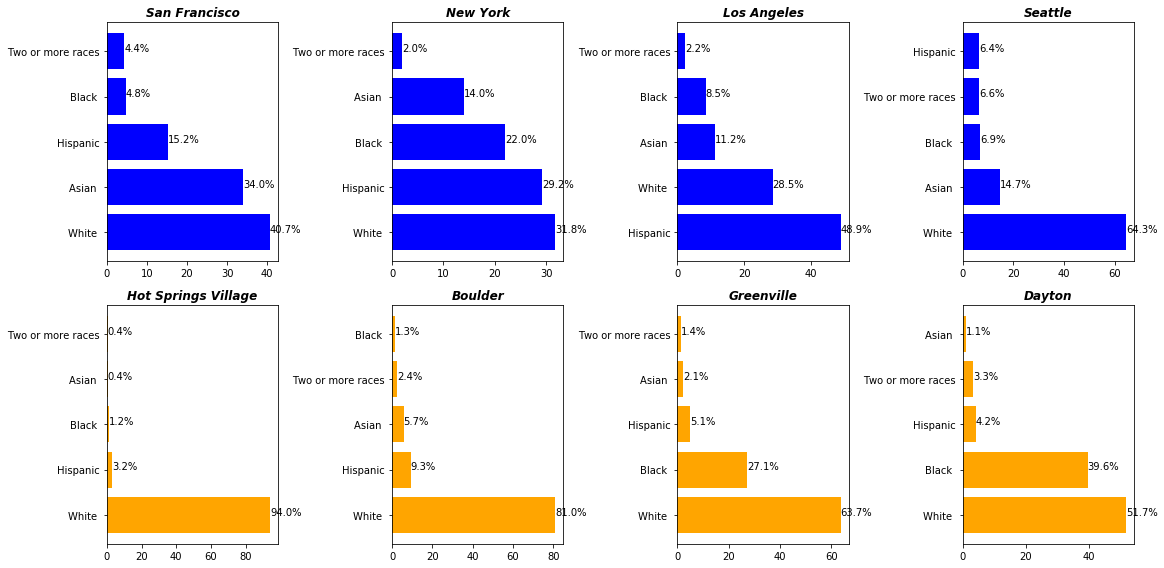

In [45]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(16,8))

for i,big_city in enumerate(big_cities):
    race = city_profile[big_city]['race_df']['race'].str.rstrip('alone').values[:5] #top 5 races
    percentage = city_profile[big_city]['race_df']['percentage(%)'].values[:5]
    ax[0,i].barh(race, percentage, color='blue')
    ax[0,i].set_title(big_city.split(',')[0], fontsize=12, style='italic',fontweight='bold')
    for j,value in enumerate(percentage):
        ax[0,i].text(value,j,str(value)+'%')
    
for i,small_city in enumerate(small_cities):
    race = city_profile[small_city]['race_df']['race'].str.rstrip('alone').values[:5] #top 5 races
    percentage = city_profile[small_city]['race_df']['percentage(%)'].values[:5]
    ax[1,i].barh(race, percentage, color='orange')
    ax[1,i].set_title(small_city.split(',')[0], fontsize=12, style='italic',fontweight='bold')
    for j,value in enumerate(percentage):
        ax[1,i].text(value,j,str(value)+'%')
plt.tight_layout()
plt.savefig('race composition barplot.jpeg')

You may find the above horizontal bar plots more clearly show the distribution.

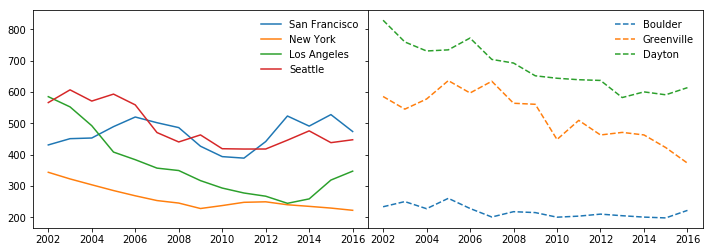

In [46]:
fig,ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,4))
fig.subplots_adjust(wspace=0)
for i,big_city in enumerate(big_cities):
    year = city_profile[big_city]['crime_df']['year'].astype(int).values
    crime_index = city_profile[big_city]['crime_df']['crime_index'].astype(float).values
    ax[0].plot(year, crime_index, linestyle='solid', label=big_city.split(',')[0])
    ax[0].legend(frameon=False)
for i,small_city in enumerate(small_cities):
    if 'crime_df' in city_profile[small_city].keys(): #if there is crime data
        year = city_profile[small_city]['crime_df']['year'].astype(int).values
        crime_index = city_profile[small_city]['crime_df']['crime_index'].astype(float).values
        ax[1].plot(year, crime_index, linestyle='dashed', label=small_city.split(',')[0])
        ax[1].legend(frameon=False)
plt.savefig('crime_index.jpeg')        

It's interesting to find out some small cities aren't the safest. However, I couldn't find the crime data for Hot Springs Village. Maybe its crime is minimum or just the data is missing.

In [37]:
city_venue_top5 = {}
city_venue_total = {}
for city in big_cities+small_cities:
    venue_onehot = pd.get_dummies(city_profile[city]['venue_df'][['venue_category']],prefix='',prefix_sep='')
    venue_top5 = venue_onehot.sum().sort_values(ascending=False)[:5].index.tolist()
    venue_total = city_profile[city]['venue_df'].shape[0]
    city_venue_top5[city] = venue_top5
    city_venue_total[city] = venue_total
    
city_venue_top5_df = pd.DataFrame(city_venue_top5.items(),columns=['city','top5 most common venues'])
for i, row in city_venue_top5_df.iterrows():
    for j, item in enumerate(row['top5 most common venues']):
        city_venue_top5_df.loc[i,'{}th most common venues'.format(j+1)] = item
city_venue_top5_df.drop('top5 most common venues',axis=1,inplace=True)

city_venue_total_df = pd.DataFrame(city_venue_total.items(),columns=['city','number of venues near downtown'])

city_venue_df = pd.merge(city_venue_top5_df,city_venue_total_df,on='city')
city_venue_df

,city,1th most common venues,2th most common venues,3th most common venues,4th most common venues,5th most common venues,number of venues near downtown
0,"San Francisco, California",Coffee Shop,Cocktail Bar,Café,Furniture / Home Store,French Restaurant,100
1,"New York, New York",Coffee Shop,Sandwich Place,Café,Italian Restaurant,Bakery,100
2,"Los Angeles, California",American Restaurant,Noodle House,Sushi Restaurant,Speakeasy,Museum,38
3,"Seattle, Washington",Hotel,Coffee Shop,Café,Cocktail Bar,Sandwich Place,100
4,"Hot Springs Village, Arkansas",Home Service,NaN,NaN,NaN,NaN,1
5,"Boulder, Colorado",Vegetarian / Vegan Restaurant,Sandwich Place,Park,Middle Eastern Restaurant,Liquor Store,6
6,"Greenville, South Carolina",Coffee Shop,Hotel,Sushi Restaurant,Southern / Soul Food Restaurant,Bar,71
7,"Dayton, Ohio",Gay Bar,Coffee Shop,American Restaurant,Sandwich Place,Bar,35


Not surprisingly, big cities have more venues near downtown area, whereas small cities have less. I just found 1 venue near Hot Springs Village! 

##  Results and Discussion <a name='results'></a>

From the above summary and comparison, we can see different aspects of life in big and small cities. While big cities enjoy higher income and convenience to various venues, they also suffer traffic jam and higher housing price. In comparison, small cities may have lower house hold income and less access to venues, they do have an advantage of more affordable housing and less crime. 

## Conclusion <a name='conclusion'></a>

This notebook is inspired by a NPR radio clip named "Are Big Cities Overrated? Economists Say Yes, In Some Cases". You can find their original interview here https://www.npr.org/2019/06/20/734496883/are-big-cities-overrated-economists-say-yes-in-some-cases. As a reference to their conclusion: You should not move to big expensive cities like New York or Seattle. Instead, they say, it's actually mid-sized cities where you should go, mainly because they have a much lower cost of living. In other words, big cities are overrated.